# Byg en klassifikationsmodel: Lækre asiatiske og indiske retter


## Klassifikatorer for køkken 1

I denne lektion vil vi udforske en række klassifikatorer for at *forudsige et givet nationalt køkken baseret på en gruppe ingredienser.* Samtidig vil vi lære mere om nogle af de måder, algoritmer kan udnyttes til klassifikationsopgaver.

### [**Quiz før lektionen**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Forberedelse**

Denne lektion bygger videre på vores [forrige lektion](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), hvor vi:

-   Lavede en blid introduktion til klassifikationer ved hjælp af et datasæt om alle de fantastiske køkkener fra Asien og Indien 😋.

-   Udforskede nogle [dplyr-verber](https://dplyr.tidyverse.org/) til at forberede og rense vores data.

-   Lavede smukke visualiseringer med ggplot2.

-   Demonstrerede, hvordan man håndterer ubalancerede data ved at forbehandle dem med [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Viste, hvordan man `prep` og `bake` vores opskrift for at sikre, at den fungerer som forventet.

#### **Forudsætninger**

Til denne lektion skal vi bruge følgende pakker til at rense, forberede og visualisere vores data:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) er en [samling af R-pakker](https://www.tidyverse.org/packages), der gør datavidenskab hurtigere, nemmere og sjovere!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) er en [rammeværk af pakker](https://www.tidymodels.org/packages/) til modellering og maskinlæring.

-   `themis`: [themis-pakken](https://themis.tidymodels.org/) tilbyder ekstra opskridt til håndtering af ubalancerede data.

-   `nnet`: [nnet-pakken](https://cran.r-project.org/web/packages/nnet/nnet.pdf) tilbyder funktioner til estimering af feed-forward neurale netværk med et enkelt skjult lag og til multinomial logistisk regressionsmodeller.

Du kan installere dem som:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativt kontrollerer scriptet nedenfor, om du har de nødvendige pakker til at gennemføre dette modul, og installerer dem for dig, hvis de mangler.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Opdel data i trænings- og testdatasæt.

Vi starter med at tage nogle trin fra vores tidligere lektion.

### Fjern de mest almindelige ingredienser, der skaber forvirring mellem forskellige køkkener, ved hjælp af `dplyr::select()`.

Alle elsker ris, hvidløg og ingefær!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfekt! Nu er det tid til at opdele dataen, så 70% af dataen går til træning og 30% til test. Vi vil også anvende en `stratificering`steknik, når vi opdeler dataen, for at `bevare proportionen af hver køkkentype` i trænings- og valideringsdatasættene.

[rsample](https://rsample.tidymodels.org/), en pakke i Tidymodels, tilbyder infrastruktur til effektiv dataopdeling og resampling:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Håndtering af ubalancerede data

Som du måske har bemærket i det oprindelige datasæt såvel som i vores træningssæt, er der en ret ujævn fordeling i antallet af køkkener. Koreanske køkkener er *næsten* 3 gange så mange som thailandske køkkener. Ubalancerede data har ofte en negativ indvirkning på modellens præstation. Mange modeller fungerer bedst, når antallet af observationer er lige, og har derfor tendens til at kæmpe med ubalancerede data.

Der er primært to måder at håndtere ubalancerede datasæt på:

-   Tilføje observationer til minoritetsklassen: `Over-sampling`, f.eks. ved brug af en SMOTE-algoritme, som syntetisk genererer nye eksempler af minoritetsklassen ved hjælp af nærmeste naboer til disse tilfælde.

-   Fjerne observationer fra majoritetsklassen: `Under-sampling`

I vores tidligere lektion demonstrerede vi, hvordan man håndterer ubalancerede datasæt ved hjælp af en `recipe`. En recipe kan betragtes som en køreplan, der beskriver, hvilke trin der skal anvendes på et datasæt for at gøre det klar til dataanalyse. I vores tilfælde ønsker vi at have en lige fordeling i antallet af vores køkkener for vores `training set`. Lad os komme i gang.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Du kan selvfølgelig gå videre og bekræfte (ved at forberede og bage), at opskriften fungerer som forventet - alle køkkenetiketter har `559` observationer.

Da vi vil bruge denne opskrift som en forbehandler til modellering, vil en `workflow()` tage sig af al forberedelse og bagning for os, så vi ikke behøver manuelt at estimere opskriften.

Nu er vi klar til at træne en model 👩‍💻👨‍💻!

## 3. Valg af din klassifikator

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Kunstværk af @allison_horst</figcaption>


Nu skal vi beslutte, hvilken algoritme vi skal bruge til opgaven 🤔.

I Tidymodels tilbyder [`parsnip-pakken`](https://parsnip.tidymodels.org/index.html) en ensartet grænseflade til at arbejde med modeller på tværs af forskellige motorer (pakker). Se venligst parsnip-dokumentationen for at udforske [modeltyper og motorer](https://www.tidymodels.org/find/parsnip/#models) samt deres tilsvarende [modelargumenter](https://www.tidymodels.org/find/parsnip/#model-args). Udvalget kan virke overvældende ved første øjekast. For eksempel inkluderer følgende metoder alle klassifikationsteknikker:

-   C5.0 Regelbaserede klassifikationsmodeller

-   Fleksible diskriminantmodeller

-   Lineære diskriminantmodeller

-   Regulariserede diskriminantmodeller

-   Logistiske regressionsmodeller

-   Multinomiale regressionsmodeller

-   Naive Bayes-modeller

-   Support Vector Machines

-   Nærmeste naboer

-   Beslutningstræer

-   Ensemblemetoder

-   Neurale netværk

Listen fortsætter!

### **Hvilken klassifikator skal man vælge?**

Så, hvilken klassifikator skal du vælge? Ofte er det en god idé at prøve flere og se, hvad der giver et godt resultat.

> AutoML løser dette problem elegant ved at udføre disse sammenligninger i skyen, så du kan vælge den bedste algoritme til dine data. Prøv det [her](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Valget af klassifikator afhænger også af vores problem. For eksempel, når resultatet kan kategoriseres i `mere end to klasser`, som i vores tilfælde, skal du bruge en `multiklassifikationsalgoritme` i stedet for `binær klassifikation.`

### **En bedre tilgang**

En bedre metode end blot at gætte er at følge ideerne på dette downloadbare [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Her opdager vi, at vi til vores multiklasseproblem har nogle valgmuligheder:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>En del af Microsofts algoritme-cheat sheet, der beskriver muligheder for multiklassifikation</figcaption>


### **Begrundelse**

Lad os se, om vi kan finde frem til forskellige tilgange givet de begrænsninger, vi har:

-   **Dybe neurale netværk er for tunge**. Givet vores rene, men minimale datasæt, og det faktum at vi kører træning lokalt via notebooks, er dybe neurale netværk for tunge til denne opgave.

-   **Ingen to-klasse klassifikator**. Vi bruger ikke en to-klasse klassifikator, så det udelukker one-vs-all.

-   **Beslutningstræ eller logistisk regression kunne fungere**. Et beslutningstræ kunne fungere, eller multinomial regression/multiklasselogistisk regression for multiklasse data.

-   **Multiklasse Boosted Decision Trees løser et andet problem**. Multiklasse boosted decision tree er mest velegnet til ikke-parametriske opgaver, f.eks. opgaver designet til at opbygge rangeringer, så det er ikke nyttigt for os.

Normalt, før man begiver sig ud i mere komplekse maskinlæringsmodeller, f.eks. ensemblemetoder, er det en god idé at bygge den enklest mulige model for at få en idé om, hvad der foregår. Så til denne lektion starter vi med en `multinomial regression` model.

> Logistisk regression er en teknik, der bruges, når resultatvariablen er kategorisk (eller nominel). For binær logistisk regression er antallet af resultatvariable to, mens antallet af resultatvariable for multinomial logistisk regression er mere end to. Se [Avancerede regressionsmetoder](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) for yderligere læsning.

## 4. Træn og evaluer en Multinomial logistisk regressionsmodel.

I Tidymodels definerer `parsnip::multinom_reg()` en model, der bruger lineære prædiktorer til at forudsige multiklasse data ved hjælp af den multinomiale fordeling. Se `?multinom_reg()` for de forskellige måder/engines, du kan bruge til at tilpasse denne model.

I dette eksempel vil vi tilpasse en Multinomial regressionsmodel via den standard [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> Jeg valgte en værdi for `penalty` lidt tilfældigt. Der er bedre måder at vælge denne værdi på, nemlig ved at bruge `resampling` og `tuning` af modellen, som vi vil diskutere senere.
>
> Se [Tidymodels: Kom i gang](https://www.tidymodels.org/start/tuning/) hvis du vil lære mere om, hvordan man tuner modelhyperparametre.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Godt gået 🥳! Nu hvor vi har en opskrift og en modelspecifikation, skal vi finde en måde at samle dem i et objekt, der først forbehandler dataene, derefter tilpasser modellen på de forbehandlede data og også muliggør potentielle efterbehandlingsaktiviteter. I Tidymodels kaldes dette praktiske objekt en [`workflow`](https://workflows.tidymodels.org/) og indeholder bekvemt dine modelleringskomponenter! Dette er, hvad vi ville kalde *pipelines* i *Python*.

Så lad os samle det hele i en workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! En **`workflow()`** kan tilpasses på næsten samme måde som en model. Så, tid til at træne en model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Outputtet viser de koefficienter, som modellen lærte under træningen.

### Evaluér den Trænede Model

Det er tid til at se, hvordan modellen klarede sig 📏 ved at evaluere den på et testdatasæt! Lad os starte med at lave forudsigelser på testdatasættet.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Godt arbejde! I Tidymodels kan evaluering af modelpræstation udføres ved hjælp af [yardstick](https://yardstick.tidymodels.org/) - en pakke, der bruges til at måle modellernes effektivitet ved hjælp af præstationsmetrikker. Som vi gjorde i vores lektion om logistisk regression, lad os begynde med at beregne en forvekslingsmatrix.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Når man arbejder med flere klasser, er det generelt mere intuitivt at visualisere dette som et varmekort, sådan her:


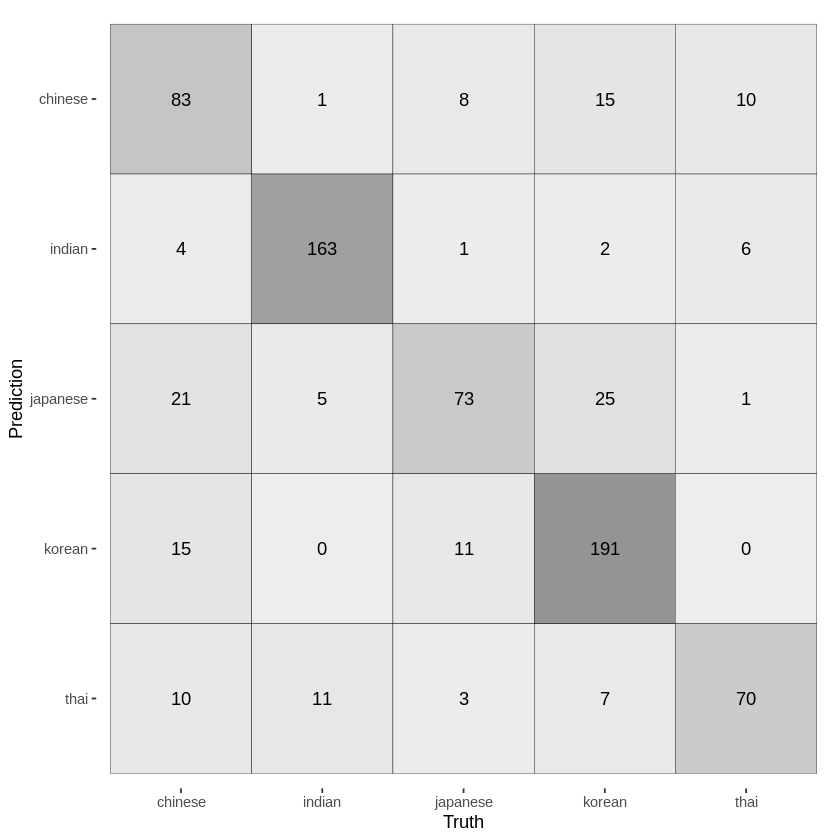

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

De mørkere felter i forvirringsmatricens plot angiver et højt antal tilfælde, og forhåbentlig kan du se en diagonal linje af mørkere felter, der viser de tilfælde, hvor den forudsagte og den faktiske etiket er de samme.

Lad os nu beregne sammenfattende statistikker for forvirringsmatricen.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Hvis vi ser på nogle metrics såsom nøjagtighed, sensitivitet, ppv, er vi ikke helt dårligt stillet som udgangspunkt 🥳!

## 4. Gå i dybden

Lad os stille et subtilt spørgsmål: Hvilke kriterier bruges til at afgøre, hvilken type køkken der vælges som det forudsagte resultat?

Statistiske maskinlæringsalgoritmer, som logistisk regression, er baseret på `sandsynlighed`; så det, der faktisk bliver forudsagt af en klassifikator, er en sandsynlighedsfordeling over et sæt af mulige resultater. Klassen med den højeste sandsynlighed vælges derefter som det mest sandsynlige resultat for de givne observationer.

Lad os se dette i praksis ved at lave både hårde klasseforudsigelser og sandsynligheder.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Meget bedre!

✅ Kan du forklare, hvorfor modellen er ret sikker på, at den første observation er thailandsk?

## **🚀Udfordring**

I denne lektion brugte du dine rensede data til at bygge en maskinlæringsmodel, der kan forudsige en national køkkenstil baseret på en række ingredienser. Tag dig tid til at læse om de [mange muligheder](https://www.tidymodels.org/find/parsnip/#models), som Tidymodels tilbyder til at klassificere data, og [andre metoder](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) til at tilpasse multinomial regression.

#### TAK TIL:

[`Allison Horst`](https://twitter.com/allison_horst/) for at skabe de fantastiske illustrationer, der gør R mere indbydende og engagerende. Find flere illustrationer i hendes [galleri](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) og [Jen Looper](https://www.twitter.com/jenlooper) for at skabe den originale Python-version af dette modul ♥️

<br>
Ville have smidt nogle jokes ind, men jeg forstår ikke mad-puns 😅.

<br>

God læring,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Ansvarsfraskrivelse**:  
Dette dokument er blevet oversat ved hjælp af AI-oversættelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selvom vi bestræber os på nøjagtighed, skal det bemærkes, at automatiserede oversættelser kan indeholde fejl eller unøjagtigheder. Det originale dokument på dets oprindelige sprog bør betragtes som den autoritative kilde. For kritisk information anbefales professionel menneskelig oversættelse. Vi påtager os intet ansvar for misforståelser eller fejltolkninger, der måtte opstå som følge af brugen af denne oversættelse.
